In [1]:
# Running on GPU?

import setGPU

setGPU: Setting GPU to: 3


In [2]:
import math
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.axes_grid1 import make_axes_locatable

import keras
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, load_model
from keras.layers import (Dense, Flatten, Reshape, Conv1D,
                          MaxPooling1D, AveragePooling1D,
                          UpSampling1D, InputLayer)

from scipy import ndimage
from skimage.transform import resize

from sklearn import svm
from sklearn.ensemble import IsolationForest
from sklearn.externals import joblib
from sklearn.metrics import (accuracy_score, confusion_matrix,
                             roc_curve, auc)
from sklearn.model_selection import (cross_val_score, train_test_split,
                                     StratifiedKFold, GridSearchCV)
from sklearn.preprocessing import MaxAbsScaler
from sklearn.utils import class_weight

Using TensorFlow backend.


# Local approach to Drift Tubes Digi Occupancy Anomaly Problem

* [Load data](#Load-occupancy-data-to-the-dataframe)
* [Preprocessing](#Preprocessing)
    * [Visualize preprocessing](#Visualize-preprocessing-steps)
* [Anomaly detection](#Searching-for-anomalies)
    * [Production baseline](#Production-baseline)
    * [Dataset split](#Split-the-dataset)
    * [Simple statistics](#Benchmarking-statistical-and-filter-tests)
    * [One Class SVM & Isolation Forst](#Benchmarking-SVM-and-IF)
    * [Neural Networks](#Benchmarking-neural-networks)
* [Stability](#Checking-stability)

In [3]:
# Load models from disk

LOAD_MODELS = False

In [4]:
# Set a random seed to reproduce the results

rng = np.random.RandomState(0)

In [5]:
# Change presentation settings

%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (8.0, 5.0)

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Liberation Sans']

matplotlib.rcParams["axes.spines.left"] = True
matplotlib.rcParams["axes.spines.top"] = True
matplotlib.rcParams["axes.spines.right"] = True
matplotlib.rcParams["axes.spines.bottom"] = True
matplotlib.rcParams["axes.labelsize"] = 18
matplotlib.rcParams["axes.titlesize"] = 14

matplotlib.rcParams["xtick.top"] = True
matplotlib.rcParams["ytick.right"] = True
matplotlib.rcParams["xtick.direction"] = "in"
matplotlib.rcParams["ytick.direction"] = "in"
matplotlib.rcParams["xtick.labelsize"] = 18
matplotlib.rcParams["ytick.labelsize"] = 18
matplotlib.rcParams["xtick.major.size"] = 10
matplotlib.rcParams["ytick.major.size"] = 10
matplotlib.rcParams["xtick.minor.size"] = 5
matplotlib.rcParams["ytick.minor.size"] = 5
matplotlib.rcParams["xtick.minor.visible"] = True

matplotlib.rcParams["lines.linewidth"] = 2

matplotlib.rcParams["legend.fontsize"] = 14

color_palette = {"Indigo": {
                    50: "#E8EAF6",
                    100: "#C5CAE9",
                    200: "#9FA8DA",
                    300: "#7986CB",
                    400: "#5C6BC0",
                    500: "#3F51B5",
                    600: "#3949AB",
                    700: "#303F9F",
                    800: "#283593",
                    900: "#1A237E"},
                 "Orange": {      
                    50: "#FFF3E0",
                    100: "#FFE0B2",
                    200: "#FFCC80",
                    300: "#FFB74D",
                    400: "#FFA726",
                    500: "#FF9800",
                    600: "#FB8C00",
                    700: "#F57C00",
                    800: "#EF6C00",
                    900: "#E65100"}
                }

line_styles = [(0, ()), (0, (1, 2)), (0, (3, 2))]

In [6]:
# Set data directory
# You can copy the data from /eos/cms/store/cmst3/group/dehep/adpol/dt/data

data_directory = "../data"
labels_directory = "../data"
models_directory = "../models-local"
figure_export_directory = "../figures"

## Load occupancy data to the dataframe

In [7]:
# Load occupancy data to the dataframe

runs = [272011, 272012, 272014, 272017, 272021, 272774, 273158, 273730,
        274388, 274422, 274968, 274969, 275310, 275311, 275847, 275890,
        276244, 276283, 276384, 276582, 276587, 276775, 276776, 276950,
        278509, 278820, 278822, 279694, 279766, 279794, 280018, 281693,
        281727, 281976, 282735, 282814, 284041, 284042, 284043, 284044,
        297411, 297467, 297468, 297469, 297484, 297665, 297666, 297678,
        299000, 300087, 300390, 300391, 300392, 300393, 300395, 300396,
        300397, 300398, 300399, 300497, 300558, 301142, 301383, 301384,
        302031, 302038, 302040, 302041, 302042, 302043, 302350, 302548,
        302634, 302635, 304144, 304737, 304738, 304739, 304740, 305064,
        305081, 306041, 306042, 306049]

test_run = [302634, 302635, 304737, 304738, 304739, 304740]
train_runs = [r for r in runs if r not in test_run]

drift_tubes_layers = pd.DataFrame()
for run in runs:
    print("Loading %s" % run, end="\r")
    path = "%s/%s.json" % (data_directory, run)
    drift_tubes_layers = drift_tubes_layers.append(pd.read_json(path),
                                                   ignore_index=True);
print("Done. Collected %s layers" % drift_tubes_layers.shape[0], end="\r")

In [8]:
# Transform the string of hits to list

drift_tubes_layers["content"] = drift_tubes_layers["content"].apply(eval)
drift_tubes_layers["content"] = drift_tubes_layers["content"].apply(np.array)

In [9]:
# Append score from labels data file

labels_frame = pd.read_csv(("%s/labels.csv" % labels_directory),
                           names=["wheel",
                                  "station",
                                  "sector",
                                  "run",
                                  "layer",
                                  "score"])


drift_tubes_layers = pd.merge(drift_tubes_layers,
                              labels_frame,
                              how="left",
                              on=["wheel",
                                  "station",
                                  "sector",
                                  "run",
                                  "layer"])

## Preprocessing

In [10]:
# Use median polling to remove channels with extreme values (smoothing)

SMOOTH_FILTER_SIZE = 3

def median_polling(layer):
    """Smooths layer occupancy using median filter"""
    smooth_layer = []
    for index in range(len(layer) - (SMOOTH_FILTER_SIZE-1)):
        median = np.median(layer[ index : index + SMOOTH_FILTER_SIZE ])
        smooth_layer.append(median)
    return np.array(smooth_layer)

drift_tubes_layers["content_smoothed"] = drift_tubes_layers["content"].apply(median_polling)

In [11]:
print("Minimum raw length: % s" % min(drift_tubes_layers["content"].apply(len)))
print("Maximum raw length: % s" % max(drift_tubes_layers["content"].apply(len)))
print("Minimum smoothed length: % s" % min(drift_tubes_layers["content_smoothed"].apply(len)))
print("Maximum smoothed length: % s" % max(drift_tubes_layers["content_smoothed"].apply(len)))

Minimum raw length: 47
Maximum raw length: 96
Minimum smoothed length: 45
Maximum smoothed length: 94


In [35]:
# Use linear interpolation to resize all the data samples (standardization)

def resize_occupancy(layer):
    """Resizes occupancy to a given size using bilinear interpolation"""
    return resize(np.array(layer).reshape(1, len(layer)), (1, SAMPLE_SIZE), preserve_range=True)[0]

SAMPLE_SIZE = min(drift_tubes_layers["content"].apply(len))
drift_tubes_layers["content_resized"] = drift_tubes_layers["content"].apply(resize_occupancy)

SAMPLE_SIZE = min(drift_tubes_layers["content_smoothed"].apply(len))
drift_tubes_layers["content_smoothed_resized"] = drift_tubes_layers["content_smoothed"].apply(resize_occupancy)

/opt/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [36]:
# Normalize the data (normalization)

def scale_occupancy(layer):
    """Scales layer data using MaxAbsScaler"""
    # Need to reshape since scaler works per column
    layer = layer.reshape(-1, 1)
    scaler = MaxAbsScaler().fit(layer)
    return scaler.transform(layer).reshape(1, -1)

drift_tubes_layers["content_scaled"] = drift_tubes_layers["content_resized"].apply(scale_occupancy)
drift_tubes_layers["content_smoothed_scaled"] = drift_tubes_layers["content_smoothed_resized"].apply(scale_occupancy)

### Visualize preprocessing steps

In [37]:
# Combine per layer data to per chamber data

drift_tubes_chambers = pd.DataFrame()

for run in runs:
    for wheel in range(-2, 3):
        for station in range(1, 5):
            for sector in range(1, 15):
                if labels_frame[(labels_frame.run == run) &
                                (labels_frame.wheel == wheel) &
                                (labels_frame.station == station) &
                                (labels_frame.sector == sector)].empty:
                    continue

                chamber = drift_tubes_layers[
                    (drift_tubes_layers.run == run) &
                    (drift_tubes_layers.wheel == wheel) &
                    (drift_tubes_layers.station == station) &
                    (drift_tubes_layers.sector == sector)].sort_values("layer",
                                                                       ascending=1)
                if not len(chamber):
                    continue
                
                occupancy_raw = [layer.tolist() for layer in chamber["content"]]
                occupancy_smoothed = [layer.tolist() for layer in chamber["content_smoothed"]]

                occupancy_resized = np.concatenate(
                    chamber["content_resized"].values).reshape(-1, 47)
                occupancy_scaled = np.concatenate(
                    chamber["content_scaled"].values).reshape(-1, 47)
                occupancy_smoothed_resized = np.concatenate(
                    chamber["content_smoothed_resized"].values).reshape(-1, 45)
                occupancy_smoothed_scaled = np.concatenate(
                    chamber["content_smoothed_scaled"].values).reshape(-1, 45)

                extended_size_smoothed = max((len(_) for _ in occupancy_smoothed))
                extended_size_raw = max((len(_) for _ in occupancy_raw))
                
                for index, layer in enumerate(occupancy_raw):
                    layer.extend([np.nan]*(extended_size_raw-len(layer)))
                    occupancy_raw[index] = layer

                for index, layer in enumerate(occupancy_smoothed):
                    layer.extend([np.nan]*(extended_size_smoothed-len(layer)))
                    occupancy_smoothed[index] = layer

                score = sum(chamber.score.values)
                
                data = {"run": run,
                        "wheel": wheel,
                        "station": station,
                        "sector": sector,
                        "score": score,
                        "content_raw": np.concatenate(
                            occupancy_raw).reshape(len(chamber), extended_size_raw),
                        "content_smoothed": np.concatenate(
                            occupancy_smoothed).reshape(len(chamber), extended_size_smoothed),
                        "content_resized": occupancy_resized,
                        "content_smoothed_resized": occupancy_smoothed_resized,
                        "content_scaled": occupancy_scaled,
                        "content_smoothed_scaled": occupancy_smoothed_scaled}

                drift_tubes_chambers = drift_tubes_chambers.append(pd.Series(data),
                                                                   ignore_index=True)

In [38]:
# Plotting utils

def plot_occupancy_hitmap(data, title, save_name, unit):
    """Visualizes occupancy hitmap"""
    fig, ax = plt.subplots()
    
    ax = plt.gca()
    
    ax.set_xlim([-2, data.shape[1]+1])
    ax.set_yticklabels(["1", "5", "9"])
    ax.set_yticks([0, 4, 8])
    ax.set_ylim([13,-2])

    plt.xlabel("Channel", horizontalalignment='right', x=1.0)
    plt.ylabel("Layer", horizontalalignment='right', y=1.0)
    
    # Deal with .eps export
    masked_array = np.ma.array (data, mask=np.isnan(data))
    cmap = matplotlib.cm.viridis
    cmap.set_bad("white", 1.)
    
    im = ax.imshow(data, interpolation="nearest", cmap=cmap)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    
    if unit == "a.u.":
        form = '%.2f'
    else:
        form = '%.0f'
    
    plt.colorbar(im,
                 cax=cax,
                 format=form,
                 ticks=[np.min(np.nan_to_num(data)),
                        np.max(np.nan_to_num(data))])
    
    plt.title(title, loc="right")   
    
    ax.text(1.1, 0.75, unit, rotation=90,
        verticalalignment="top", horizontalalignment="right",
        transform=ax.transAxes, color="black", fontsize=16)
    
    ax.text(0, 1.16, "CMS", weight='bold',
        verticalalignment="top", horizontalalignment="left",
        transform=ax.transAxes, color="black", fontsize=18)

    if save_name:
        fig.savefig("%s/occupancy%s.eps" % (figure_export_directory,
                                           save_name),
                    bbox_inches="tight")
    plt.show();
    
def get_title(title, show):
    """Generates title for occupancy plot"""
    return ("%sRun: %s, W: %s, St: %s, Sec: %s" % 
            (title, int(show.run), show.wheel, show.station, show.sector))

def visualize_preprocessing(show, smoothed):
    """Visualizes preprocessing steps"""
    if smoothed:
        plot_occupancy_hitmap(show.content_smoothed,
                              get_title("Smoothed Occupancy, ", show), "F", "a.u.")
        plot_occupancy_hitmap(show.content_smoothed_resized,
                              get_title("Standardized Occupancy, ", show), "G", "a.u.")
        plot_occupancy_hitmap(show.content_smoothed_scaled,
                              get_title("Scaled Occupancy, ", show), False, "a.u.") 

    else:
        plot_occupancy_hitmap(show.content_raw,
                              get_title("Raw Occupancy, ", show), "D", "counts")
        plot_occupancy_hitmap(show.content_resized,
                              get_title("Standardized Occupancy, ", show), "E", "a.u.")
        plot_occupancy_hitmap(show.content_scaled,
                              get_title("Scaled Occupancy, ", show), False, "a.u.")

Example of preprocessing pipeline for <b>chamber without problems</b>:

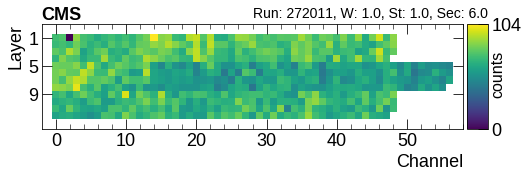

In [39]:
dt = drift_tubes_chambers[drift_tubes_chambers.score == 12].iloc[6]
plot_occupancy_hitmap(dt.content_raw, get_title("", dt), "A", "counts")

Example of preprocessing pipeline for <b>chamber with one faulty layer</b>:

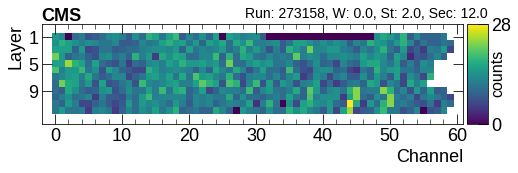

In [40]:
dt = drift_tubes_chambers[drift_tubes_chambers.score == 11].iloc[0]
plot_occupancy_hitmap(dt.content_raw, get_title("", dt), "B", "counts")

Example of preprocessing pipeline for <b>chamber with twelve faulty layer</b>:

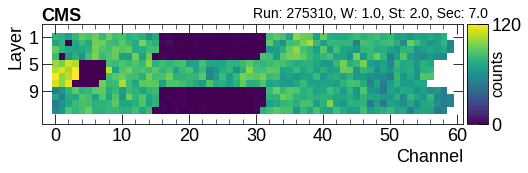

In [41]:
dt = drift_tubes_chambers[drift_tubes_chambers.score == 0].iloc[3]
plot_occupancy_hitmap(dt.content_raw, get_title("", dt), "C", "counts")

Example of <b>alternative</b> preprocessing (with median polling) pipeline for <b>chamber without problems</b>:

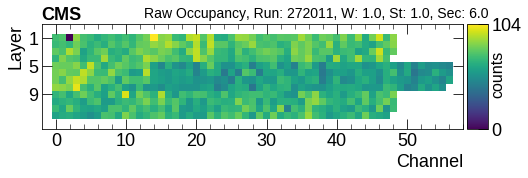

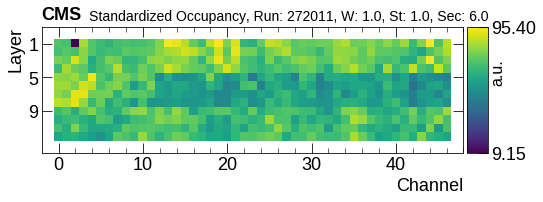

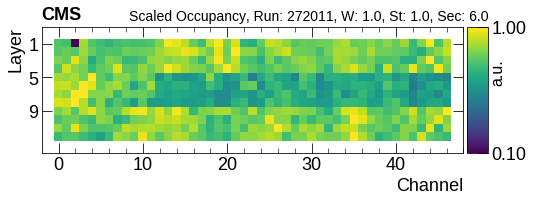

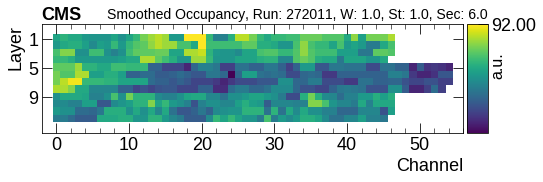

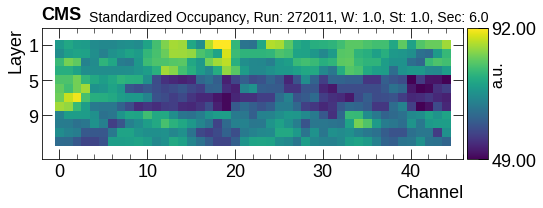

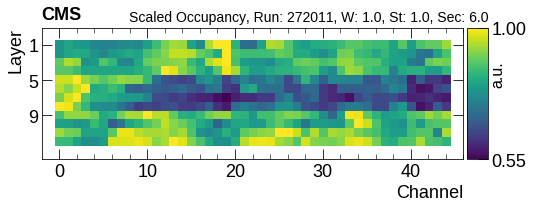

In [42]:
visualize_preprocessing(drift_tubes_chambers[drift_tubes_chambers.score == 12].iloc[6], False)
visualize_preprocessing(drift_tubes_chambers[drift_tubes_chambers.score == 12].iloc[6], True)

## Searching for anomalies

In [43]:
# Define styles for plots

lines = [(color_palette["Orange"][600], line_styles[0]),
         (color_palette["Indigo"][800], line_styles[0]),
         (color_palette["Indigo"][200], line_styles[1]),
         (color_palette["Indigo"][200], line_styles[0]),
         (color_palette["Indigo"][500], line_styles[0]),
         (color_palette["Indigo"][500], line_styles[1]),
         (color_palette["Indigo"][100], line_styles[0])]

In [44]:
# ROC Curve plotting function

def get_roc_curve(test_df, models, working_point=None):
    """Generates ROC Curves for a given array"""
    fig, ax = plt.subplots()
  
    for i, (legend_label, model_score) in enumerate(models):
        fpr, tpr, _ = roc_curve(test_df["score"], test_df[model_score])
        auc_v = round(auc(fpr, tpr), 3)
        plt.plot(fpr,
                 tpr,
                 color=lines[i][0],
                 linestyle=lines[i][1],
                 label=("%s, AUC: %s" % (legend_label, auc_v)))
        
    if working_point:
        plt.plot(1-working_point[0],
                 working_point[1],
                 "o",
                 color=color_palette["Orange"][900],
                 markersize=6,
                 label="CNN working point")

    plt.legend(frameon=False)
    plt.ylabel("Sensitivity (TPR)", horizontalalignment='right', y=1.0)
    plt.xlabel("Fall-out (1-TNR)", horizontalalignment='right', x=1.0)
    plt.xlim(0, 0.25)
    
    fig.savefig("%s/local_roc.eps" % figure_export_directory, bbox_inches="tight")
    plt.show();

In [45]:
# Calculate TPR and TNR

def benchmark(y_true, y_pred):
    """Retrun TPR and TNR"""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()   
    sensitivity = float(tp)/(tp+fn)
    specificity = float(tn)/(tn+fp)

    print("Model accuracy: %s" % round(accuracy_score(y_true, y_pred), 2))
    print("Model sensitivity: %s" % round(sensitivity, 2))
    print("Model specificity: %s" % round(specificity, 2))
    
    return specificity, sensitivity

### Production baseline

In [46]:
# Yield production algorithm results on the full labelled dataset

def production_test(content):
    """Calculate score that mirrors the test currently in production"""
    return (float(len(np.where(content == 0)[0])) / len(np.where(~np.isnan(content))[0]))

drift_tubes_chambers["treshold"] = drift_tubes_chambers["content_raw"].apply(production_test)
benchmark(drift_tubes_chambers["score"] < 12, drift_tubes_chambers["treshold"] > 0.1);

Model accuracy: 0.63
Model sensitivity: 0.26
Model specificity: 0.91


### Split the dataset

In [47]:
def change_score(score):
    return -(2*score-1)

# Change the score (GOOD: 0, BAD: 1)
drift_tubes_layers["score"] = drift_tubes_layers["score"].apply(change_score)

# Get only labelled samples
drift_tubes_layers_scored = drift_tubes_layers[~np.isnan(drift_tubes_layers.score)]
anomalies = drift_tubes_layers_scored[drift_tubes_layers_scored.score == 1]
normalies = drift_tubes_layers_scored[drift_tubes_layers_scored.score == -1]
print("%s faults and %s good samples. In total: %s." %
      (len(anomalies), len(normalies), len(anomalies) + len(normalies)))

# Split the labelled dataset
anomalies_train, anomalies_test = train_test_split(anomalies, test_size = 0.2, random_state=rng)
normalies_train, normalies_test = train_test_split(normalies, test_size = 0.2, random_state=rng)

# Get startified split for neural network validation
neural_anomalies_train, neural_anomalies_val = train_test_split(anomalies_train,
                                                                test_size = 0.2,
                                                                random_state=rng)
neural_normalies_train, neural_normalies_val = train_test_split(normalies_train,
                                                                test_size = 0.2,
                                                                random_state=rng)

# Prepare set for training SVM, IF etc....
layers_train = pd.concat([anomalies_train, normalies_train])
layers_test = pd.concat([anomalies_test, normalies_test])

# Prepare training/val sets for neural networks
neural_train = pd.concat([neural_anomalies_train, neural_normalies_train])
neural_val = pd.concat([neural_anomalies_val, neural_normalies_val])

print("Number of anomalies in the train set: %s" % len(anomalies_test))
print("Number of normal in the train set: %s" % len(normalies_test))

612 faults and 5668 good samples. In total: 6280.
Number of anomalies in the train set: 123
Number of normal in the train set: 1134


### Benchmarking statistical and filter tests

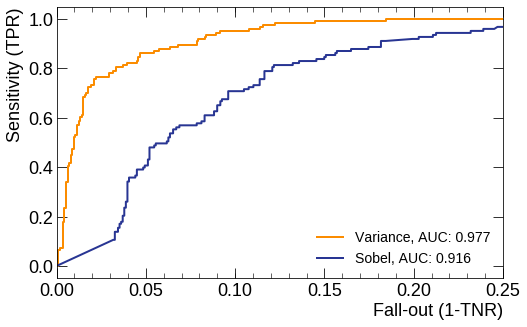

In [48]:
def sobel(content):
    return max(abs(ndimage.sobel(content)[0]))

def variance(content):
    return np.var(content)
    
layers_test["sobel_score"] = layers_test["content_smoothed_scaled"].apply(sobel)
layers_test["variance_score"] = layers_test["content_smoothed_scaled"].apply(variance)

get_roc_curve(layers_test, [("Variance", "variance_score"),
                            ("Sobel", "sobel_score")])

### Benchmarking SVM and IF

In [49]:
# Cross validate model selection using Stratified5Fold and GridSearchCV

def cross_validation_spit(train_X, train_y, clf_i, param_grid, return_params=False):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=rng)
    clf = GridSearchCV(clf_i, param_grid, cv=skf, scoring="roc_auc"); 
    clf.fit(train_X, train_y)
    if return_params:
        return clf.best_params_
    return clf.best_estimator_

In [52]:
# Training SVM, this may take some time...

if LOAD_MODELS:
    svmclf = joblib.load("%s/svm.pkl" % models_directory) 
else:
    param_grid = [{"nu": np.array(range(1, 10, 1))/10.0,
                   "gamma": [0.1, 0.01, 0.001, 0.0001],
                   "kernel": ["linear", "rbf"]}]

    svmparams = cross_validation_spit(np.concatenate(
        layers_train["content_smoothed_scaled"].values),
                                      -layers_train["score"],
                                      svm.OneClassSVM(random_state=rng),
                                      param_grid)
    
    # Retrain SVM using only good samples
    svmclf = svm.OneClassSVM(nu=svmparams.nu,
                             gamma=svmparams.gamma,
                             kernel=svmparams.kernel,
                             random_state=rng)
    
    svmclf.fit(np.concatenate(
        normalies_train["content_smoothed_scaled"].values));
    
    joblib.dump(svmclf, "%s/svm.pkl" % models_directory) 
    
print(svmclf)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.1, kernel='rbf',
      max_iter=-1, nu=0.40000000000000002,
      random_state=<mtrand.RandomState object at 0x7f05b6bb84c8>,
      shrinking=True, tol=0.001, verbose=False)


In [53]:
# Training IF, this may take some time...

if LOAD_MODELS:
    ifclf = joblib.load("%s/if.pkl" % models_directory) 
else:
    param_grid = [{"max_samples": [100, 1000],
                   "n_estimators": [10, 100],
                   "contamination": np.array(range(0, 10, 1)) / 100.0}]

    ifparams = cross_validation_spit(np.concatenate(
        layers_train["content_smoothed_scaled"].values),
                                     -layers_train["score"],
                                     IsolationForest(random_state=rng),
                                     param_grid)
    
    # Retrain IF using all unlabelled samples
    ifclf = IsolationForest(max_samples=ifparams.max_samples,
                            n_estimators=ifparams.n_estimators,
                            contamination=ifparams.contamination,
                            random_state=rng)
    
    ifclf.fit(np.concatenate(drift_tubes_layers[np.isnan(
        drift_tubes_layers.score)]["content_smoothed_scaled"].values));
    
    joblib.dump(ifclf, "%s/if.pkl" % models_directory) 
    
print(ifclf)

IsolationForest(bootstrap=False, contamination=0.0, max_features=1.0,
        max_samples=1000, n_estimators=100, n_jobs=1,
        random_state=<mtrand.RandomState object at 0x7f05b6bb84c8>,
        verbose=0)


In [54]:
# Train BDT if you fancy...

# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import AdaBoostClassifier
# from sklearn.metrics import classification_report, roc_auc_score

# bdtclf = DecisionTreeClassifier(class_weight="balanced",
#                              random_state=rng)

# abdtclf = AdaBoostClassifier(bdtclf)

# abdtclf.fit(np.concatenate(
#     layers_train["content_smoothed_scaled"].values),
#             layers_train["score"])

# print(abdtclf.get_params())

# layers_test["bdt_score"] = abdtclf.decision_function(
#     np.array(np.concatenate(
#         layers_test["content_smoothed_scaled"].values)))

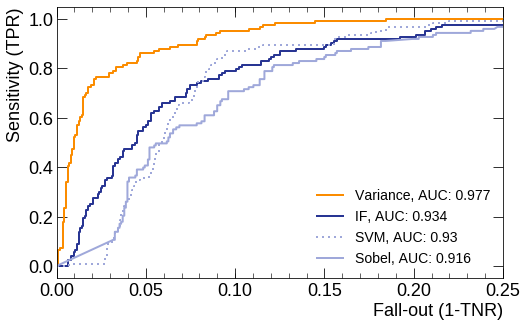

In [55]:
layers_test["svm_score"] = -svmclf.decision_function(
    np.concatenate(layers_test["content_smoothed_scaled"].values))
layers_test["if_score"] = -ifclf.decision_function(
    np.concatenate(layers_test["content_smoothed_scaled"].values))

get_roc_curve(layers_test,[("Variance", "variance_score"),                           
                           ("IF", "if_score"),
                           ("SVM", "svm_score"),
                           ("Sobel", "sobel_score")])

### Benchmarking neural networks

In [56]:
# Start Keras session

sess = tf.Session()
K.set_session(sess)

In [57]:
# Generate CNN input

def score_to_array(score):
    if score == -1:
        return np.asarray([1, 0])
    return np.asarray([0, 1])

def generate_input():  
    return (np.array(np.concatenate(neural_train.content_scaled.values)).reshape(-1, 47),
            np.concatenate(neural_train["score"].apply(score_to_array).values).reshape(-1, 2),
            np.array(np.concatenate(neural_val.content_scaled.values)).reshape(-1, 47),
            np.concatenate(neural_val["score"].apply(score_to_array).values).reshape(-1, 2),
            np.array(np.concatenate(layers_test.content_scaled.values)).reshape(-1, 47))

(train_x, train_y, val_x, val_y, test_x) = generate_input()

In [88]:
# Define networks

def shallow_neural_network():
    model = Sequential()
    model.add(Reshape((47, 1), input_shape=(47,), name="input_snn"))
    model.add(Flatten(name="flatten_snn"))
    model.add(Dense(16, name="dense_snn", activation="relu"))
    model.add(Dense(2, activation="softmax", name="output_snn"))
    return model

def convolutional_neural_network():
    model = Sequential()
    model.add(Reshape((47, 1), input_shape=(47,), name="input_cnn"))
    model.add(Conv1D(10, 3, strides=1, padding="valid", name="convolution_cnn", activation="relu"))
    model.add(MaxPooling1D(pool_size=5, strides=5, padding="valid", name="polling_cnn"))
    model.add(Flatten(name="flatten_cnn"))
    model.add(Dense(8, name="dense_cnn", activation="relu"))
    model.add(Dense(2, activation="softmax", name="output_cnn"))
    return model

snn = shallow_neural_network()
cnn = convolutional_neural_network()
print("Shallow Neural Network Architecture:")
snn.summary()
print("Convolutional Network Architecture:")
cnn.summary()

Shallow Neural Network Architecture:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_snn (Reshape)          (None, 47, 1)             0         
_________________________________________________________________
flatten_snn (Flatten)        (None, 47)                0         
_________________________________________________________________
dense_snn (Dense)            (None, 16)                768       
_________________________________________________________________
output_snn (Dense)           (None, 2)                 34        
Total params: 802
Trainable params: 802
Non-trainable params: 0
_________________________________________________________________
Convolutional Network Architecture:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_cnn (Reshape)          (None, 47, 1)             0         
_____

In [89]:
# Train neural networks

def train_nn(model, x, y, batch_size, loss, name, validation_data=None, 
             validation_split=0.0, class_weight=None):

    model.compile(loss=loss, optimizer="adam")

    early_stopper = EarlyStopping(monitor="val_loss",
                                  patience=32,
                                  verbose=True,
                                  mode="auto")
    
    checkpoint_callback = ModelCheckpoint(("%s/%s.h5" % (models_directory, name)),
                                          monitor="val_loss",
                                          verbose=False,
                                          save_best_only=True,
                                          mode="min")
    return model.fit(x, y,
                     batch_size=batch_size,
                     epochs=8192,
                     verbose=False,
                     class_weight=class_weight,
                     initial_epoch=0,
                     shuffle=True,
                     validation_split=validation_split,
                     validation_data=validation_data,
                     callbacks=[early_stopper, checkpoint_callback])

In [90]:
# Calculate weights for different classes

cw = class_weight.compute_class_weight("balanced",
                                       np.unique(np.argmax(train_y, axis=1)),
                                       np.argmax(train_y, axis=1))
cw = {0: cw[0], 1: cw[1]}

In [92]:
# Train SNN, this may take some time...

if not LOAD_MODELS:
    history_snn = train_nn(snn,
                           train_x,
                           train_y,
                           len(train_x),
                           keras.losses.categorical_crossentropy,
                           "snn",
                           validation_data=(val_x, val_y),
                           class_weight=cw)
    
    history_snn = history_snn.history
    
    with open("%s/history-snn.pkl" % models_directory, "wb+") as history:
        pickle.dump(history_snn, history)

else:
    with open("%s/history-snn.pkl" % models_directory, "rb") as history:
        history_snn = pickle.load(history)

Epoch 01866: early stopping


In [79]:
# Train CNN, this may take some time...

if not LOAD_MODELS:
    history_cnn = train_nn(cnn,
                           train_x,
                           train_y,
                           len(train_x),
                           keras.losses.categorical_crossentropy,
                           "cnn",
                           validation_data=(val_x, val_y),
                           class_weight=cw)
    
    history_cnn = history_cnn.history
    
    with open("%s/history-cnn.pkl" % models_directory, "wb+") as history:
        pickle.dump(history_cnn, history)

else:
    with open("%s/history-cnn.pkl" % models_directory, "rb") as history:
        history_cnn = pickle.load(history)

Epoch 01471: early stopping


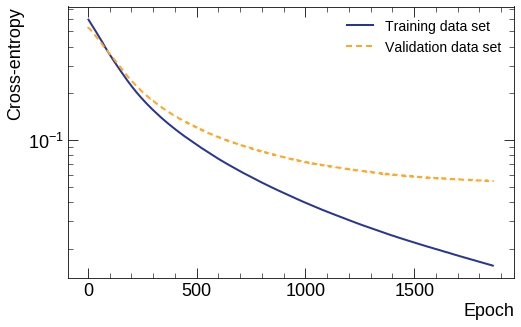

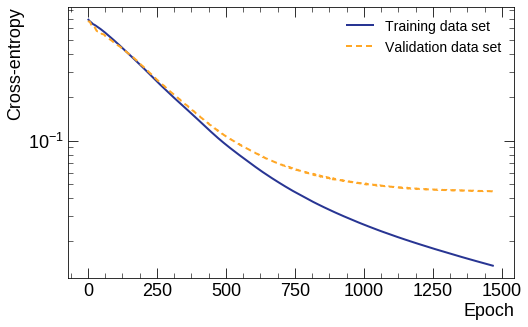

In [93]:
# Plot loss vs. epoch

def plot_loss(data):
    """Plots the training and validation loss"""
    fig, ax = plt.subplots()

    plt.xlabel("Epoch", horizontalalignment='right', x=1.0)
    plt.ylabel("Cross-entropy", horizontalalignment='right', y=1.0)

    plt.plot(data["loss"], linestyle=line_styles[0], color=color_palette["Indigo"][800])
    plt.plot(data["val_loss"], linestyle=line_styles[2], color=color_palette["Orange"][400])
    plt.legend(["Training data set", "Validation data set"], loc="upper right", frameon=False)
    plt.yscale("log")
    
    fig.savefig("%s/local_loss.eps" % figure_export_directory, bbox_inches="tight")
    plt.show();

plot_loss(history_snn)
plot_loss(history_cnn)

In [94]:
# Export models as .pb, needed for CMSSW implementation:

# outputs = [cnn.output.name.split(":")[0]]
# print("Input name: %s" % cnn.inputs[0].name.split(":")[0])
# print("Output name: %s" % outputs[0])
# constant_graph = tf.graph_util.convert_variables_to_constants(sess, sess.graph.as_graph_def(), outputs);
# tf.train.write_graph(constant_graph, "../model-new", "constantgraph.pb", as_text=False);

In [95]:
# Reload models from saved

snn_model = load_model("%s/snn.h5" % models_directory)
cnn_model = load_model("%s/cnn.h5" % models_directory)

In [96]:
# Calculate score for trained networks:

layers_test["snn_score"] = snn_model.predict(np.array(test_x))[:, 1]
layers_test["cnn_score"] = cnn_model.predict(np.array(test_x))[:, 1]

In [97]:
specificity, sensitivity = benchmark(layers_test["score"] == 1, layers_test["cnn_score"] > 0.5)

Model accuracy: 0.99
Model sensitivity: 0.96
Model specificity: 0.99


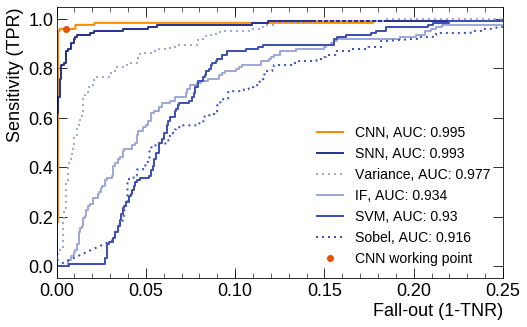

In [98]:
get_roc_curve(layers_test,
              [("CNN", "cnn_score"),
               ("SNN", "snn_score"),
               ("Variance", "variance_score"),
               ("IF", "if_score"),
               ("SVM", "svm_score"),
               ("Sobel", "sobel_score")],
               #("Decision Tree", "bdt_score")],
              (specificity, sensitivity))

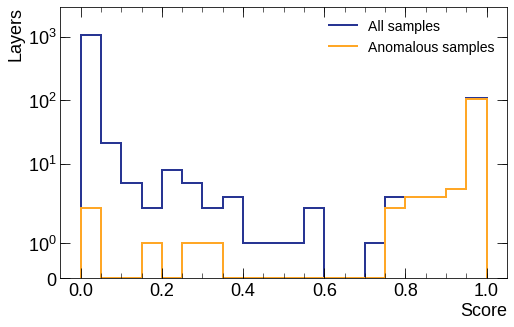

In [99]:
# Score distribution

filter = layers_test["score"] == 1

fig, ax = plt.subplots()

plt.hist(layers_test["cnn_score"],
         label = "All samples",
         facecolor = "None",
         linewidth = 2,
         histtype = 'step',
         edgecolor = color_palette["Indigo"][800],
         bins= np.arange(0, 1.05, 0.05))

plt.hist(layers_test["cnn_score"][filter],
         label = "Anomalous samples",
         facecolor = "None",
         linewidth = 2,
         histtype = 'step',
         edgecolor = color_palette["Orange"][400],
         bins=np.arange(0, 1.05, 0.05))

import matplotlib.lines as mlines
import matplotlib.pyplot as plt

leg1 = mlines.Line2D([], [], color=color_palette["Indigo"][800], marker='',
                          markersize=10, label='All samples')
leg2 = mlines.Line2D([], [], color=color_palette["Orange"][400], marker='',
                          markersize=10, label='Anomalous samples')

l = plt.legend(frameon=False, handles=[leg1, leg2])
plt.yscale("symlog")
plt.xlabel("Score", horizontalalignment='right', x=1.0)
plt.ylabel("Layers", horizontalalignment='right', y=1.0)
plt.ylim(0, 3000)
plt.subplots_adjust(hspace=0.9)

fig.savefig("%s/local_score.eps" % figure_export_directory, bbox_inches="tight")
plt.show();

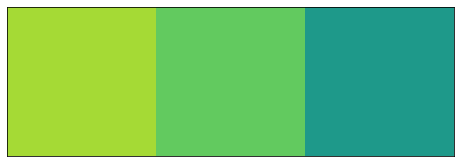

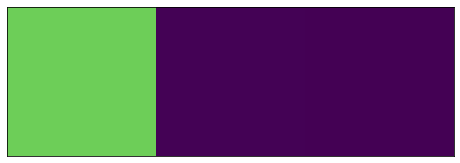

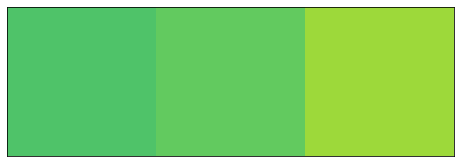

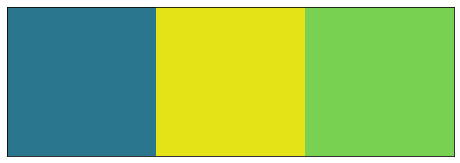

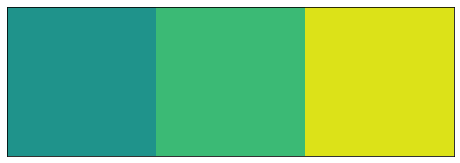

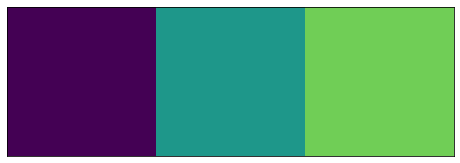

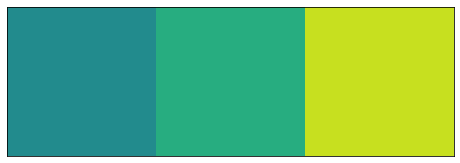

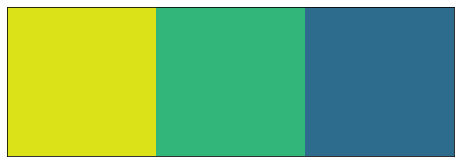

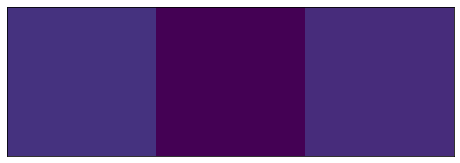

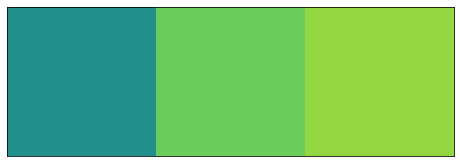

In [100]:
# Show convolutional filters

weights = cnn_model.layers[1].get_weights()[0]

for layer_filter in range(weights.shape[2]):
    plt.imshow(weights[:,:,layer_filter].reshape(1,-1), interpolation='nearest', vmin=-1, vmax=1)
    plt.xticks([])
    plt.yticks([])
    plt.show()

## Checking stability

In [101]:
# Load data
# Had to be generated before loading in the notebook because ROOT/Notebook import issues

total_no_layers = 2721
total_no_chambers = 250
runs = [306777, 306793, 306794]

drift_tubes_alarms = pd.DataFrame()

for run in runs:
    print("Loading %s" % run, end="\r")
    path = "%s/%sST.csv" % (data_directory, run)
    drift_tubes_alarms = drift_tubes_alarms.append(pd.read_csv(path),
                                                   ignore_index=True);
print("Done          ", end="\r")

In [102]:
# Add data points for lumi=0

for run in runs:
    df_zero = pd.DataFrame({"lumi": [0],
                            "current_dqm": [total_no_chambers],
                            "total": [0],
                            "emerging": [0],
                            "run": run})
    drift_tubes_alarms = pd.concat([df_zero, drift_tubes_alarms],
                                   ignore_index=True,
                                   sort=False)

In [103]:
# Calculate fraction of alarms

drift_tubes_alarms["total"] = drift_tubes_alarms["total"] / total_no_layers
drift_tubes_alarms["emerging"] = drift_tubes_alarms["emerging"] / total_no_layers
drift_tubes_alarms["current_dqm"] = drift_tubes_alarms["current_dqm"] / total_no_chambers

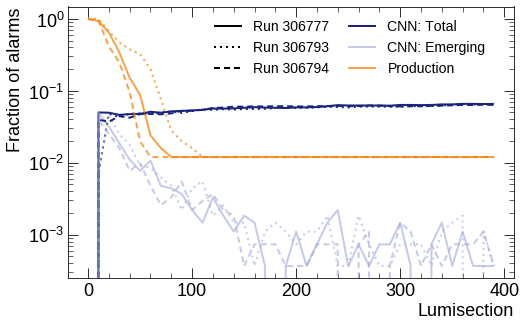

In [104]:
# Plot stability vs. lumi

fig, ax = plt.subplots()

for i, (run, line_type) in enumerate(zip(runs, line_styles)):
    df = drift_tubes_alarms[drift_tubes_alarms.run == run].sort_values("lumi",
                                                                       ascending=1)

    plt.plot(df["lumi"],
             df["total"],
             linestyle=line_type,
             color=color_palette["Indigo"][900],
             alpha=1,
             label="CNN: Total" if i == 0 else "")

    plt.plot(df["lumi"],
             df["emerging"],
             linestyle=line_type,
             color=color_palette["Indigo"][200],
             alpha=0.6,
             label="CNN: Emerging" if i == 0 else "")

    plt.plot(df["lumi"],
             df["current_dqm"],
             linestyle=line_type,
             color=color_palette["Orange"][700],
             alpha=0.7,
             label="Production" if i == 0 else "")

plt.xlabel("Lumisection", horizontalalignment='right', x=1.0)
plt.ylabel("Fraction of alarms", horizontalalignment='right', y=1.0)

plt.yscale("log")

legend_helper =[]
for i in range(len(runs)):
    legend_helper.append(mlines.Line2D([],
                                       [],
                                       linestyle=line_styles[i],
                                       color="black",
                                       label="Run %s" % runs[i]))

legend_runs = plt.legend(handles=legend_helper, frameon=False, bbox_to_anchor=(0.3, 0.7))

plt.legend(frameon=False, bbox_to_anchor=(0.6, 0.7))
plt.gca().add_artist(legend_runs)
fig.savefig("%s/local_stability.eps" % figure_export_directory, bbox_inches="tight")
plt.show()